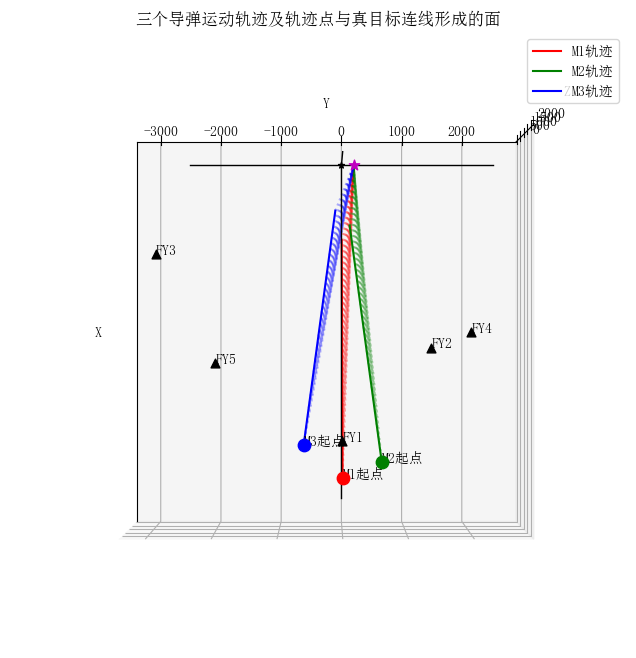

In [14]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = ["SimSun"]
plt.rcParams['axes.unicode_minus'] = False

# 三个导弹初始点
missile_starts = [
    np.array([20000, 0, 2000]),
    np.array([19000, 600, 2100]),
    np.array([18000, -600, 1900])
]
# 真目标

drone_pos = {
    0: np.array([17800,0,1800]),
    1: np.array([12000,1400,1400]),
    2: np.array([6000,-3000,700]),
    3: np.array([11000,2000,1800]),
    4: np.array([13000,-2000,1300])
}
true_target = np.array([0, 200, 0])

# 轨迹参数
missile_v = 300  # m/s
t_list = np.linspace(0, 50, 401)  # 0~60s, 每秒一个点

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'g', 'b']
labels = ['M1', 'M2', 'M3']

for i in range(3):
    # 导弹方向（指向假目标原点）
    missile_dir = (np.array([0, 0, 0]) - missile_starts[i]) / np.linalg.norm(np.array([0, 0, 0]) - missile_starts[i])
    # 轨迹
    traj = missile_starts[i][:, np.newaxis] + missile_v * t_list * missile_dir[:, np.newaxis]
    ax.plot(traj[0], traj[1], traj[2], color=colors[i], label=f'{labels[i]}轨迹')
    # 起点标记
    ax.scatter(missile_starts[i][0], missile_starts[i][1], missile_starts[i][2], color=colors[i], marker='o', s=80)
    ax.text(missile_starts[i][0], missile_starts[i][1], missile_starts[i][2], f'{labels[i]}起点', fontsize=10)
    # 轨迹上的每一点与真目标连线（形成面）
    for j in range(0, len(t_list), 20):  # 每隔20个点画一条连线，避免太密集
        ax.plot([traj[0][j], true_target[0]], [traj[1][j], true_target[1]], [traj[2][j], true_target[2]],
                color=colors[i], linestyle=':', alpha=0.3)

# 坐标原点标记
for i in range(5):
    ax.scatter(drone_pos[i][0], drone_pos[i][1], drone_pos[i][2], color='k', marker='^', s=40)
    ax.text(drone_pos[i][0], drone_pos[i][1], drone_pos[i][2], f'FY{i+1}', fontsize=10)
ax.scatter(0, 0, 0, color='k', marker='*')
ax.text(0, 0, 0, s=' ', fontsize=10)

# 真目标标记
ax.scatter(true_target[0], true_target[1], true_target[2], color='m', marker='*', s=60)
ax.plot([0, 22000], [0, 0], [0, 0], color='k', linestyle='-', linewidth=1)  # X轴
ax.plot([0, 0], [-2500, 2500], [0, 0], color='k', linestyle='-', linewidth=1)  # Y轴
ax.plot([0, 0], [0, 0], [0, 2200], color='k', linestyle='-', linewidth=1)  # Z轴
ax.set_xticks([])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('三个导弹运动轨迹及轨迹点与真目标连线形成的面')
ax.legend()
ax.view_init(elev=90, azim=0)  
plt.show()

In [ ]:
# 总有效遮蔽时间
missile_pos = np.array([
    [20000, 0, 2000],
    [19000, 600, 2100],
    [18000, -600, 1900]
])  # shape: (N_missile, 3)
drone_pos = {
    0: np.array([17800,0,1800]),
    1: np.array([12000,1400,1400]),
    2: np.array([6000,-3000,700]),
    3: np.array([11000,2000,1800]),
    4: np.array([13000,-2000,1300])
}
v_M=300
t_start, t_end, t_step = 0, 67, 0.02
t_list = np.arange(t_start, t_end + t_step, t_step)  # shape: (T,)
target=np.array([0,200,5])

#导弹轨迹
def get_missile_traj(start, target, v=v_M, t_list=t_list):
    """
    start: np.array([x0, y0, z0]) 导弹初始点
    target: np.array([x1, y1, z1]) 目标点
    v: float 导弹速度（m/s）
    t_list: np.array 时间轴
    返回: (3, T) 导弹轨迹
    """
    direction = (target - start) / np.linalg.norm(target - start)
    traj = start[:, np.newaxis] + v * t_list * direction[:, np.newaxis]
    return traj

trajs = np.array([get_missile_traj(missile_pos[i], target) for i in range(len(missile_pos))])  # shape: (N_missile, 3, T)
# 3. 烟幕球心轨迹函数
def get_smoke_center(position, direction_angle, speed, throw_times, burst_delays, t_list=t_list):
    """
    direction_angle: float, 方向角度（0~2pi）
    burst_delays: list of 3 floats, 每次投掷对应一个爆炸延迟
    """
    smoke_centers = []
    smoke_v0 = -3  # 竖直初速度
    g = 9.80655
    smoke_duration = 20  # 烟幕持续时间
    direction = np.array([np.cos(direction_angle), np.sin(direction_angle), 0.0])
    for idx, throw_time in enumerate(throw_times):
        burst_delay = burst_delays[idx]
        t_burst = throw_time + burst_delay
        valid_idx = (t_list >= t_burst) & (t_list <= t_burst + smoke_duration)
        smoke_center = np.ones((3, len(t_list))) * 1e5  # 未爆炸时高度设为1e5
        smoke_start = position + direction * speed * t_burst - 0.5 * np.array([0, 0, g]) * t_burst**2
        t_valid = t_list[valid_idx] - t_burst
        smoke_center[:, valid_idx] = smoke_start.reshape(3, 1)
        smoke_center[2, valid_idx] += smoke_v0 * t_valid  # 仅竖直速度，无重力
        smoke_centers.append(smoke_center)
    return smoke_centers  # list of (3, T)
# 4. 遮蔽判定函数
def get_missile_cover_time(smoke_centers, missile_traj, target=np.array([0,200,5]), smoke_radius=10, t_list=t_list):
    """
    smoke_centers: list of (3, T) 烟幕球心轨迹
    missile_traj: (3, T) 导弹轨迹
    target: np.array([x1, y1, z1]) 目标点
    smoke_radius: float, 烟幕半径
    t_list: np.array, 时间轴
    返回: float, 导弹被遮蔽总时间
    """

    covered = np.zeros(len(t_list), dtype=int)
    for smoke_center in smoke_centers:
        # 对每个时刻，计算球心到直线的距离
        # 公式：| (P - A) × (B - A) | / |B - A|，A为起点，B为终点，P为球心
        P = np.array(smoke_center).T  # shape (T, 3)
        A = missile_traj.T
        B = np.broadcast_to(target, A.shape)  # shape (T, 3)
        AB = B - A
        AB = np.array(AB)
        AP = np.array(P - A)

        cross = np.cross(AP, AB)  # shape (T, 3)
        dist = np.linalg.norm(cross, axis=1) / np.linalg.norm(AB, axis=1)  # shape (T,)

        covered |= (dist < smoke_radius)
    total_cover_time = np.sum(covered) * (t_list[1] - t_list[0])
    return total_cover_time
# 5. 总流程函数
def compute_all_missile_cover(drone_params, missile_positions, t_list=t_list):
    """
    drone_params: 包含无人机序号、方向角度、速度、投掷时刻、爆炸延迟等
    missile_positions: 导弹轨迹列表
    返回: 各导弹被遮蔽总时间
    """
    results = []
    smoke_centers = []
    for drone in drone_params:
        smoke_centers += get_smoke_center(**drone, t_list=t_list)
    for missile_pos in missile_positions:
        cover_time = get_missile_cover_time(smoke_centers, missile_pos)
        results.append(cover_time)
    return results

drone_params = [{
    'position': np.array([17800,0,1800]),
    'direction_angle': 0.0,
    'speed': 20,
    'throw_times': [10, 20, 30],
    'burst_delays': [2.0, 2.0, 2.0]
    },{
    'position': np.array([12000,1400,1400]),
    'direction_angle': 0.0,
    'speed': 20,
    'throw_times': [10, 20, 30],
    'burst_delays': [2.0, 2.0, 2.0]
    },{
    'position': np.array([6000,-3000,700]),
    'direction_angle': 0.0,
    'speed': 20,
    'throw_times': [10, 20, 30],
    'burst_delays': [2.0, 2.0, 2.0]
    },{
    'position': np.array([11000,2000,1800]),
    'direction_angle': 0.0,
    'speed': 20,
    'throw_times': [10, 20, 30],
    'burst_delays': [2.0, 2.0, 2.0]
    },{
    'position': np.array([13000,-2000,1300]),
    'direction_angle': 0.0,
    'speed': 20,
    'throw_times': [10, 20, 30],
    'burst_delays': [2.0, 2.0, 2.0]
    }
 ]

cover_times = compute_all_missile_cover(drone_params, trajs)
print(cover_times)

[0.0, 0.0, 0.0]


In [ ]:
from sko.PSO import PSO

# 优化目标函数
def pso_objective(x):
    # x: [angle1, s1, t1_1, t1_2, t1_3, b1_1, b1_2, b1_3, ..., angle5, s5, t5_1, t5_2, t5_3, b5_1, b5_2, b5_3]
    drone_params_opt = []
    for i in range(5):
        angle = x[i*8]
        direction_angle = angle
        speed = x[i*8+1]
        throw_times = [x[i*8+2], x[i*8+3], x[i*8+4]]
        burst_delays = [x[i*8+5], x[i*8+6], x[i*8+7]]
        # 投弹时间约束：后一个必须大于前一个，且后一个-1也必须大于前一个
        if throw_times[1] < throw_times[0] or throw_times[2] < throw_times[1]:
            return 1e6
        if throw_times[1]-1 < throw_times[0] or throw_times[2]-1 < throw_times[1]:
            return 1e6
        drone_params_opt.append({
            'position': list(drone_pos.values())[i],
            'direction_angle': direction_angle,
            'speed': speed,
            'throw_times': throw_times,
            'burst_delays': burst_delays
        })
    # 计算所有导弹被遮蔽总时长
    total_cover_time = 0.0
    for missile_idx in range(len(missile_pos)):
        missile_traj = get_missile_traj(missile_pos[missile_idx], target, v_M, t_list)
        smoke_centers = []
        for drone in drone_params_opt:
            smoke_centers += get_smoke_center(**drone, t_list=t_list)
        cover_time = get_missile_cover_time(smoke_centers, missile_traj, target, smoke_radius=10, t_list=t_list)
        total_cover_time += cover_time
    # PSO是最小化，这里返回负值
    return -total_cover_time

# 粒子群参数
num_dim = 5 * 8  # 每个无人机8个变量（1方向+1速度+3投掷+3爆炸延迟）
lb = []
ub = []
for i in range(5):
    lb += [0, 70, 0, 0, 0, 0.5, 0.5, 0.5]  # angle范围[0,2pi]
    ub += [2*np.pi, 140, 60, 60, 60, 5, 5, 5]

pso = PSO(func=pso_objective,
          dim=num_dim, 
          pop=160, 
          max_iter=400, 
          lb=lb, 
          ub=ub,
          w=0.8, 
          c1=2, 
          c2=0.1,)
pso.run()

无人机1参数：
  方向角度: 1.523 rad
  速度: 131.7399657604953
  投弹时刻: [28.542294969107488, 1.242157824811816, 29.816356997699202]
  爆炸延迟: [0.887613033788722, 4.065392251435559, 2.054693689153754]
无人机2参数：
  方向角度: 1.051 rad
  速度: 94.34046341448969
  投弹时刻: [53.13429983906546, 45.58984588009618, 36.959008831233135]
  爆炸延迟: [1.4978836011257712, 3.9906332358422483, 4.940410432373241]
无人机3参数：
  方向角度: 3.164 rad
  速度: 78.08966097826448
  投弹时刻: [43.343513649092365, 46.15052586350249, 5.775320104813392]
  爆炸延迟: [1.2173277035388559, 2.941108390631825, 2.7985893359060388]
无人机4参数：
  方向角度: 2.160 rad
  速度: 135.28952280020223
  投弹时刻: [45.93107795622101, 9.78018342869413, 59.89209922113806]
  爆炸延迟: [4.083726186054628, 1.7164479761060631, 3.6137917519632987]
无人机5参数：
  方向角度: 5.523 rad
  速度: 71.23625358852301
  投弹时刻: [1.5914174655446445, 52.63650382524999, 6.486743046557328]
  爆炸延迟: [1.6537923350562647, 1.2420317468348574, 1.4619153202366855]
最大True数量: -1000000.0


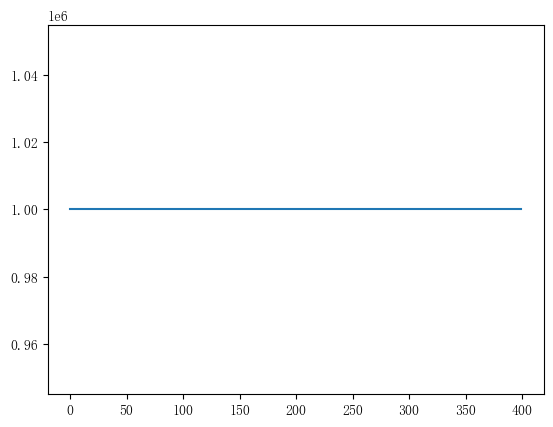

In [74]:
best_x = np.array(pso.gbest_x).flatten()
best_y = pso.gbest_y
for i in range(5):
    angle = best_x[i*8]
    speed = best_x[i*8+1]
    throw_times = [best_x[i*8+2], best_x[i*8+3], best_x[i*8+4]]
    burst_delays = [best_x[i*8+5], best_x[i*8+6], best_x[i*8+7]]
    print(f"无人机{i+1}参数：")
    print(f"  方向角度: {angle:.3f} rad")
    print(f"  速度: {speed}")
    print(f"  投弹时刻: {throw_times}")
    print(f"  爆炸延迟: {burst_delays}")
print('最大True数量:', -best_y)
plt.plot(pso.gbest_y_hist)